Created by 642115004 Kitdanai Palee

# Libraries

In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import PorterStemmer
import pandas as pd
import string
from ordered_set import OrderedSet
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sparse


In [2]:
def get_and_clean_data():
    data = pd.read_csv('../Resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description


# 39-42

From HandOn3(1)

In [3]:
def create_stem_cache(cleaned_description):
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache

def create_custom_preprocessor(stop_dict, stem_cache):
    def custom_preprocessor(s):
        ps = PorterStemmer()
        s = re.sub(r'[^A-Za-z]', ' ', s)
        s = re.sub(r'\s+', ' ', s)
        s = word_tokenize(s)
        s = list(OrderedSet(s) - stop_dict)
        s = [word for word in s if len(word)>2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = ' '.join(s)
        return s
    return custom_preprocessor

def sk_vectorize(texts, cleaned_description, stop_dict, stem_cache):
    my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
    vectorizer.fit(cleaned_description)
    query = vectorizer.transform(texts)
    print(query)
    print(vectorizer.inverse_transform(query))

In [4]:
arr = np.array([[100, 200, 200, 50], [90, 200, 300, 0], [5, 200, 10, 200]])

data = pd.DataFrame(arr, index=['DevOpsHandbook', 'ContinuousDelivery', 'DistributedComputing'], columns=['business', 'computer', 'git', 'parallel'])
data = np.log10(data + 1)

print(data.loc['DevOpsHandbook'].dot(data.loc['ContinuousDelivery']))
print(data.loc['DevOpsHandbook'].dot(data.loc['DistributedComputing']))
print(data.loc['ContinuousDelivery'].dot(data.loc['DistributedComputing']))


14.939885194377618
13.195777686137449
9.410303606094942


Length normalisation

In [5]:
data.loc['DevOpsHandbook'] /= np.sqrt((data.loc['DevOpsHandbook'] ** 2).sum())
data.loc['ContinuousDelivery'] /= np.sqrt((data.loc['ContinuousDelivery'] ** 2).sum())
data.loc['DistributedComputing'] /= np.sqrt((data.loc['DistributedComputing'] ** 2).sum())
print(data.to_markdown())


|                      |   business |   computer |      git |   parallel |
|:---------------------|-----------:|-----------:|---------:|-----------:|
| DevOpsHandbook       |   0.478543 |   0.549901 | 0.549901 |   0.407692 |
| ContinuousDelivery   |   0.501071 |   0.589096 | 0.633951 |   0        |
| DistributedComputing |   0.221882 |   0.656732 | 0.296942 |   0.656732 |


Dot product

In [6]:
print(data.loc['DevOpsHandbook'].dot(data.loc['ContinuousDelivery']))
print(data.loc['DevOpsHandbook'].dot(data.loc['DistributedComputing']))
print(data.loc['ContinuousDelivery'].dot(data.loc['DistributedComputing']))


0.9123394651809296
0.8983513789958276
0.6863034317623423


In [7]:
cleaned_description = get_and_clean_data()
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words('English'))
sk_vectorize(['python is simpler than java'], cleaned_description, stop_dict, stem_cache)

  (0, 13947)	1
  (0, 21383)	1
  (0, 24234)	1
[array(['java', 'python', 'simpler'], dtype='<U124')]


In [8]:
my_custom_preprocessor = create_custom_preprocessor(stop_dict,stem_cache)
vectoriser = CountVectorizer(preprocessor=my_custom_preprocessor)
vectoriser.fit(cleaned_description)
print(vectoriser.get_feature_names_out())

['aa' 'aaa' 'aaacad' ... 'zycron' 'zyknekz' 'zynq']


In [9]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True)
tf_idf_vectorizer.fit(cleaned_description)
transformed_data = tf_idf_vectorizer.transform(cleaned_description)
X_tfidf_df = pd.DataFrame(transformed_data.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
max_term = X_tfidf_df.sum().sort_values()[-10:].sort_index().index
X_tfidf_df[max_term].head(5)


,applic,design,develop,employ,provid,requir,respons,system,test,work
0,0.044218,0.046397,0.057155,0.030353,0.028125,0.022774,0.026645,0.000000,0.078244,0.020490
1,0.031692,0.033254,0.054619,0.000000,0.000000,0.032645,0.038194,0.000000,0.000000,0.029371
2,0.047755,0.000000,0.041152,0.032782,0.030375,0.024596,0.000000,0.027089,0.056336,0.044258
3,0.000000,0.000000,0.056202,0.000000,0.041483,0.000000,0.000000,0.036995,0.038469,0.030222
4,0.031692,0.033254,0.054619,0.000000,0.000000,0.032645,0.038194,0.000000,0.000000,0.029371


# 43

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# CountVectorizer
count_vectorized_data = vectoriser.transform(cleaned_description)

# TfidfVectorizer
tfidf_vectorized_data = tf_idf_vectorizer.transform(cleaned_description)

# Docu,emt at row #0
cosine_sim_count = cosine_similarity(count_vectorized_data[0], count_vectorized_data).flatten()

# Top 5 based on CountVectorizer
top_5_count_indices = cosine_sim_count.argsort()[-6:-1][::-1]

print("Top 5 most relevant documents using CountVectorizer:")
for idx in top_5_count_indices:
    print(f"Document at row #{idx} - Similarity: {cosine_sim_count[idx]:.4f}")

# Similarity the query "aws devops" 
query_vectorized = tf_idf_vectorizer.transform(["aws devops"])
cosine_sim_tfidf_query = cosine_similarity(query_vectorized, tfidf_vectorized_data).flatten()

# Top 5 based on TfidfVectorizer and the query
top_5_tfidf_query_indices = cosine_sim_tfidf_query.argsort()[-6:-1][::-1]

print("\nTop 5 most relevant documents using TfidfVectorizer and the query 'aws devops':")
for idx in top_5_tfidf_query_indices:
    print(f"Document at row #{idx} - Similarity: {cosine_sim_tfidf_query[idx]:.4f}")


Top 5 most relevant documents using CountVectorizer:
Document at row #4188 - Similarity: 0.6792
Document at row #1711 - Similarity: 0.6791
Document at row #2387 - Similarity: 0.6651
Document at row #4214 - Similarity: 0.6636
Document at row #2290 - Similarity: 0.6631

Top 5 most relevant documents using TfidfVectorizer and the query 'aws devops':
Document at row #4014 - Similarity: 0.1613
Document at row #513 - Similarity: 0.1539
Document at row #2180 - Similarity: 0.1511
Document at row #2395 - Similarity: 0.1511
Document at row #1797 - Similarity: 0.1318


# 80

In [11]:
import matplotlib.pyplot as plt

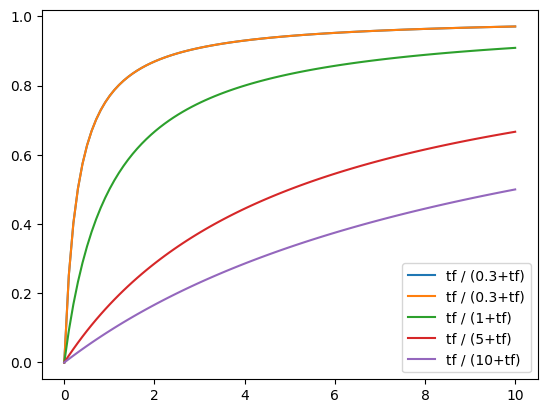

In [12]:
tf = np.linspace(0, 10, 100)
for k in [0.3,0.3,1,5,10]:
    plt.plot(tf, tf / (k+tf), label="tf / ("+str(k)+"+tf)")
plt.legend()
plt.show()

# 86

In [13]:
class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = self.y.sum(1).mean()

    def transform(self, q):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl = self.b, self.k1, self.avdl

        # apply CountVectorizer
        len_y = self.y.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = y.multiply(np.broadcast_to(idf, y.shape))*(k1+1)
        return (numer / denom).sum(1).A1
        


# 87

In [14]:
cleaned_description = get_and_clean_data()
bm25 = BM25(tf_idf_vectorizer)
bm25.fit(cleaned_description)

score = bm25.transform('aws devops')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())

score = bm25.transform('aws github')
rank = np.argsort(score)[::-1]


|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [15]:
print(cleaned_description.iloc[rank[:5]].to_markdown())

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# 22-39

In [16]:
X = vectoriser.transform(cleaned_description)

N = len(cleaned_description)
df = np.array((X.todense() > 0).sum(0))[0]
idf = np.log10(1 + (N / df))

tf = np.log10(X.todense() + 1)

tf_idf = np.multiply(tf, idf)

X = sparse.csr_matrix(tf_idf)

# Display the TF-IDF matrix
print(X.toarray())

X_df = pd.DataFrame(X.toarray(), columns=vectoriser.get_feature_names_out())

max_term = X_df.sum().sort_values()[-20:].sort_index().index

X_df[max_term]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,applic,commun,design,develop,employ,experi,includ,manag,product,program,provid,requir,respons,support,system,team,technolog,test,use,work
0,0.162810,0.203833,0.169439,0.183138,0.137024,0.095808,0.122223,0.202949,0.134365,0.12785,0.127158,0.105262,0.120846,0.000000,0.000000,0.105974,0.113112,0.236987,0.189653,0.096707
1,0.102722,0.128604,0.106904,0.145133,0.000000,0.095808,0.000000,0.128046,0.000000,0.00000,0.000000,0.105262,0.120846,0.000000,0.000000,0.105974,0.179279,0.000000,0.000000,0.096707
2,0.162810,0.000000,0.000000,0.145133,0.137024,0.095808,0.000000,0.000000,0.134365,0.00000,0.127158,0.105262,0.000000,0.000000,0.114391,0.105974,0.000000,0.187808,0.000000,0.153277
3,0.000000,0.000000,0.000000,0.145133,0.000000,0.095808,0.000000,0.000000,0.212963,0.00000,0.127158,0.000000,0.000000,0.123916,0.114391,0.167965,0.000000,0.118493,0.000000,0.096707
4,0.102722,0.128604,0.106904,0.145133,0.000000,0.095808,0.000000,0.128046,0.000000,0.00000,0.000000,0.105262,0.120846,0.000000,0.000000,0.105974,0.179279,0.000000,0.000000,0.096707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7578,0.162810,0.203833,0.106904,0.183138,0.000000,0.095808,0.244446,0.202949,0.000000,0.12785,0.127158,0.166836,0.191537,0.196402,0.181305,0.105974,0.179279,0.187808,0.000000,0.153277
7579,0.205443,0.000000,0.169439,0.212616,0.217178,0.000000,0.122223,0.202949,0.212963,0.12785,0.254316,0.166836,0.120846,0.247832,0.181305,0.105974,0.179279,0.118493,0.000000,0.096707
7580,0.102722,0.128604,0.000000,0.091569,0.000000,0.095808,0.122223,0.128046,0.000000,0.12785,0.127158,0.105262,0.000000,0.123916,0.114391,0.105974,0.113112,0.118493,0.000000,0.000000
7581,0.102722,0.128604,0.169439,0.212616,0.000000,0.095808,0.122223,0.000000,0.000000,0.12785,0.000000,0.166836,0.120846,0.123916,0.114391,0.167965,0.179279,0.000000,0.000000,0.153277


In [17]:
bigram_vectorizer = CountVectorizer(preprocessor= my_custom_preprocessor, ngram_range=(2, 2))
bigram_vectorizer.fit(cleaned_description)
print(len(bigram_vectorizer.get_feature_names_out()))

365825


In [18]:
X = bigram_vectorizer.transform(cleaned_description)
N = len(cleaned_description)
df = np.array((X.todense()>0).sum(0))[0]
idf = np.log10(1+(N / df))
tf = np.log10(X.todense()+1)
tf_idf = np.multiply(tf, idf)
X = sparse.csr_matrix(tf_idf)
X_df = pd.DataFrame(X.toarray(),columns=bigram_vectorizer.get_feature_names_out())
max_term = X_df.sum().sort_values()[-20:].sort_index().index
X_df[max_term].head(20)

,bachelor degre,color religion,comput scienc,degre comput,design develop,equal employ,gender ident,nation origin,orient gender,peopl say,qualifi applic,race color,read peopl,regard race,say work,sexual orient,softwar develop,veteran statu,without regard,year experi
0,0.000000,0.213943,0.164126,0.0000,0.000000,0.240992,0.214809,0.191082,0.236177,0.000000,0.000000,0.00000,0.000000,0.217938,0.00000,0.186518,0.132351,0.233432,0.213428,0.000000
1,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.132351,0.000000,0.000000,0.000000
2,0.000000,0.213943,0.000000,0.0000,0.000000,0.240992,0.000000,0.191082,0.000000,0.000000,0.249122,0.20557,0.000000,0.217938,0.00000,0.000000,0.132351,0.233432,0.213428,0.000000
3,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.132351,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.132351,0.000000,0.000000,0.000000
5,0.000000,0.213943,0.164126,0.0000,0.000000,0.000000,0.214809,0.191082,0.236177,0.000000,0.249122,0.20557,0.000000,0.217938,0.00000,0.186518,0.132351,0.233432,0.213428,0.000000
6,0.168525,0.000000,0.164126,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.132351,0.000000,0.000000,0.000000
7,0.168525,0.000000,0.164126,0.0000,0.219148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.132351,0.000000,0.000000,0.246634
8,0.000000,0.000000,0.000000,0.0000,0.219148,0.240992,0.000000,0.000000,0.000000,0.000000,0.249122,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
